# Import Data Analytic Tool/Package

In [ ]:
#import libraries for data analytics
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

In [ ]:
#import libraries for visualization
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Datasets

## Trip record data

In [ ]:
#read the csv data
df = pd.read_csv("data0609nyc2.csv")
#show the first 5 rows
df.head()

,Unnamed: 0,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,pickup_hour,dropoff_hour,pickup_index_right,pickup_zone,pickup_LocationID,pickup_borough,dropoff_index_right,dropoff_zone,dropoff_LocationID,dropoff_borough
0,0,0,9/6/2016,9/6/2016,1,5.22,-73.981720,40.736668,-73.981636,40.670242,...,21,21,105,Gramercy,107,Manhattan,179.0,Park Slope,181.0,Brooklyn
1,1,50,9/6/2016,9/6/2016,1,3.30,-73.988739,40.736511,-73.959511,40.776134,...,21,21,105,Gramercy,107,Manhattan,234.0,Upper East Side North,236.0,Manhattan
2,2,78,9/6/2016,9/6/2016,1,1.48,-73.988640,40.733940,-74.008301,40.736279,...,21,21,105,Gramercy,107,Manhattan,156.0,Meatpacking/West Village West,158.0,Manhattan
3,3,83,9/6/2016,9/6/2016,1,3.64,-73.985786,40.738289,-74.012650,40.716217,...,21,21,105,Gramercy,107,Manhattan,229.0,TriBeCa/Civic Center,231.0,Manhattan
4,4,109,9/6/2016,9/6/2016,5,3.45,-73.984528,40.736660,-73.952919,40.780170,...,21,21,105,Gramercy,107,Manhattan,261.0,Yorkville West,263.0,Manhattan


## Create a sql database

In [ ]:
#import necessary library
from sqlalchemy import create_engine
# create a sql dataset
nyc_database = create_engine('sqlite:///nyc_database.db')

In [ ]:
# convert dataframe to sql data table
df.to_sql('table_record', nyc_database)

ValueError: Table 'table_record' already exists.

# Design attribute of basemap

In [ ]:
def get_lat_lon(sf):
  """
  Defines the function of get_lat_lon
      input: shapefile
      output: pandas dataframe containing the location attributes
  """

    # add a new empty list
    content = []
    #Reading the "geometry data" of the shapefile file using for-loop
    for sr in sf.shapeRecords():    #read location and attributes for each item 
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        # calculate the value of longitude and latitude from creating shapefile 
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y)) #add to the list of content
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])  #returns panda dataframe with locationID, longitude and latitude columns

In [ ]:
def get_boundaries(sf):
  """
  Defines the function of get_boundaries 
      input: shapefile
      output: pandas dataframe containing the bounding area
  """
    # add empty lists of longitude and latitude
    lat, lon = [], []
    # add longitude and latitude to list within shapefile by using for-loop
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range   
    lat_min = min(lat) - margin    #defines latitude minimum
    lat_max = max(lat) + margin    #defines latitude maximum
    lon_min = min(lon) - margin    #defines longitude minimum
    lon_max = max(lon) + margin    #defines longitude maximum

    return lat_min, lat_max, lon_min, lon_max    #returns panda dataframe with minimum latitude and longitude and maximum latitude and longitude columns

In [ ]:
def draw_region_map(ax, sf, heat={}):
  """
  Defines the function of draw_region_map
      input: ax(axis), sf(shapefile), heat(value for heatmap) 
      output: map for region
  """
    continent = [235/256, 151/256, 78/256]    #defines location of continent to be viewed on map
    ocean = (89/256, 171/256, 227/256)        #defines location of ocean to be viewed on map
    
    # add the new list for display the name and vlaue
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'Brooklyn':5}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Brooklyn':[]}
    
    # display colorbar of heatmap, if count of heatmap values is not 0
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))    
        cm=plt.get_cmap('Reds')    #colour to vary according to shades of red
    
    # assign the color, shape, name for ocean by a for-loop
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:    #if count under heatmap is 0,
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')    #define by colour palette of Pastel1
            R,G,B,A = cm(norm(reg_list[reg_name]))   #Use built in colour maps of matplotlib, colour to be normalised according to individual boroughs 
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))    #otherwise, assign other colours
            col = [R,G,B]
            
        # check number of parts
        nparts = len(shape.parts) # check for length of total parts in shapefile
        if nparts == 1:    #if shapefile parts is exactly 1
            polygon = Polygon(shape.points)    #create polygon
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)   #specify transparency, colour of polygon
            ax.add_patch(patch)    #add on polygon colour path with assigned transparency
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])    #polygon based on points within i
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2) #specify colour and transparency patterns
                ax.add_patch(patch)    #add polygon patch
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)    #add on boundaing area for x coordinates for boroughs
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)    #add on boundaing area for y coordinates for boroughs
        
    for k in reg_list:   #commence for loop for all items in boroughs
        if len(heat)==0: #if count in heatmap value is exactly 0
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     #specify customisations for matplotlib plotting of map
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)      #specify customisations for matplotlib plotting of map  

    # display limits
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [ ]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
  """
  Defines the function of draw_zone_map
      input: ax(layout of plot), sf(shapefile), heat(value for heatmap), text, arrows
      output: map for zone
  """
    continent = [235/256, 151/256, 78/256] #defines location of continent to be viewed on map
    ocean = (89/256, 171/256, 227/256)     #defines location of ocean to be viewed on map
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()   #specifies degree 
    ax.set_facecolor(ocean)   #sets colour for ocean
    
    # display colorbar
    if len(heat) != 0:    #if count of heatmap value is not 0
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')    #define by colour palette of Reds
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm) #plot using variables defined earlier
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))    #sets colorbar style
    
    # display the color, shape, name by a loop
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:   #if count for values on heatmap is 0
            col = continent  #then acknowledge as continent
        else:    
            if loc_id not in heat:    #else, if location id is not in heatmap 
                R,G,B,A = cm(norm(0)) #normalise cm colour 
            else:                     
                R,G,B,A = cm(norm(heat[loc_id]))  #if location id is in heatmap value
            col = [R,G,B]     #specify colour for continent

        # check number of parts (could use MultiPolygon class of shapefile)
        nparts = len(shape.parts) # count total parts of shapefile
        if nparts == 1:   #if number of parts is 1
            polygon = Polygon(shape.points)   #extract points of polygon from shapefile
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)   #specify colours and transparency for polygon patch
            ax.add_patch(patch)   #add polygon patch
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)   #specify color for polygon patchh
                ax.add_patch(patch)    #add polygon patch to file 
        
        x = (shape.bbox[0]+shape.bbox[2])/2    #bounding areas for x coordinates
        y = (shape.bbox[1]+shape.bbox[3])/2    #bounding ares for y coordinates
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):     #if there is no text and shape area more then 0.0001
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            #text to be added according to these specifications
        elif len(text) != 0 and loc_id in text:   #else if text characters are more than 0 and text contains location id
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])   #specify x coordinates as adjusted degree 
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])   #specify y coordinates as adjusted degree 
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))    #annotate with the above coordinates 
    if len(arrows)!=0:    #if length of arrows is not 0
        for arr in arrows:    #for items in arrows
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))    #annotate with the specifications
    
    # specify boundaries and plot with boundaries in mind
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

# Read the shpfile of taxi zones and display the study area

In [ ]:
#read the shpfile of taxi_zones
sf = shapefile.Reader("NYC_taxi_zones/NYC_taxi_zones.shp")
# show the field name in each field
fields_name = [field[0] for field in sf.fields[1:]]
# add a new dictionary "shp_dic"
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
# take records to attributes
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# define the dataframe of df_loc, join pd and get_lat_lon based on the field of LocationID
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
# display 5 rows of df_loc
df_loc.head(5)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
1,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
3,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
4,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,9.640990e+05,157533.672063


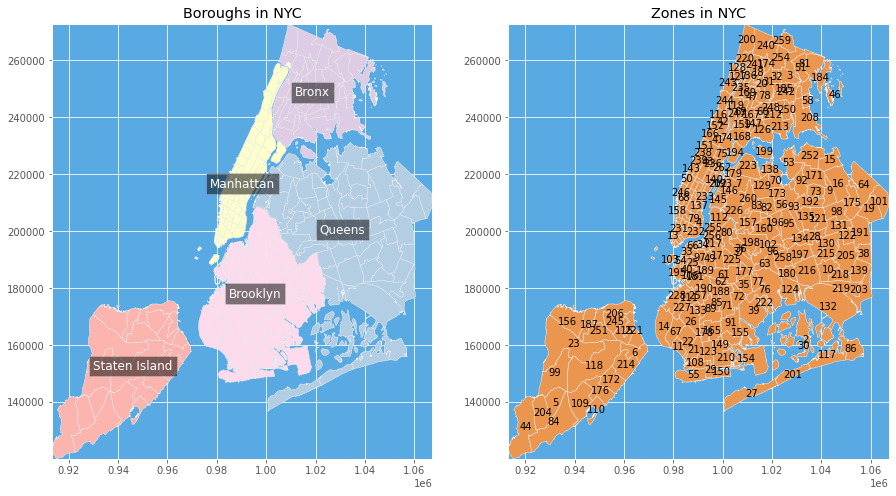

In [ ]:
# display the study area
# subplot(nrows,ncols,plot_number): Divide figure into subgraphs of nrows*ncols
# nrows：Number of rows of subgraphs
# ncols: Number of columns of subgraphs

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

# Find out the top 3 boroughs and taxi zones with most pickups and dropoffs

In [ ]:
# use sql commands to count pickup points in each taxi zone
df_pu = pd.read_sql_query('SELECT pickup_LocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_LocationID', nyc_database)
# use sql commands to count dropoff points in each taxi zone
df_do = pd.read_sql_query('SELECT dropoff_LocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_LocationID', nyc_database)

In [ ]:
# select the zones with most pickups and drop-offs
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
# Concatenate df_pu and df_do
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                  .sort_values(by=['LocationID'])
# define the TOTALcount equals to PUcount + DOcount
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
# define the dataframe of loc and df_ql
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

# sort top 3 PUcount and DOcount
# create a dictionary of pickup counts
PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist())) 
# sort taxi zones by pickup counts and only list the top three
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)  
# create a dictionary of dropoff counts
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist())) 
# sort taxi zones by dropoff counts and only list the top three
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

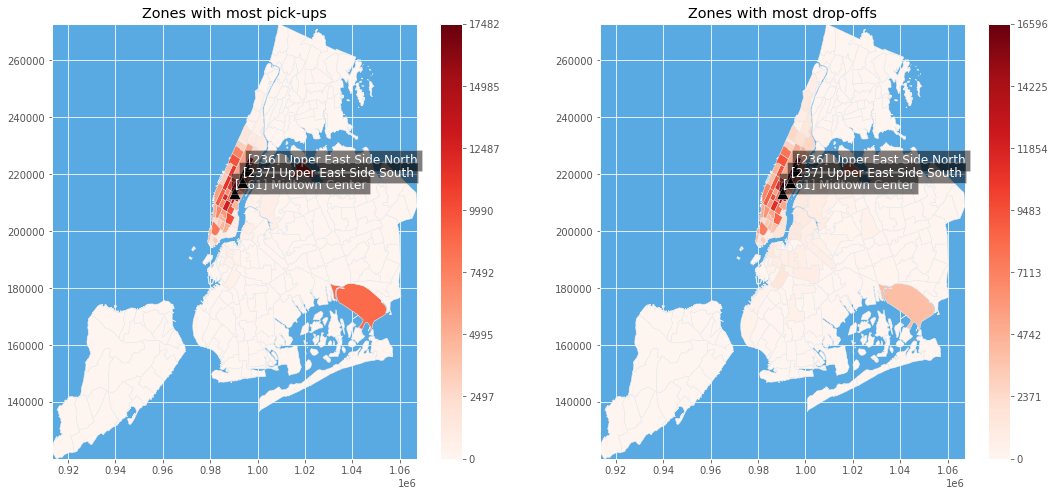

In [ ]:
# display the taxi zones with most pickups and dropoffs
# subplot(nrows,ncols,plot_number): Divide figure into subgraphs of nrows*ncols
# nrows：Number of rows of subgraphs
# ncols: Number of columns of subgraphs

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pick-ups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

In [ ]:
#Sort the boroughs in descending order of number of pick-ups and drop-offs
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)

# display the table of df_q1_region
df_q1_region

,borough,PUcount,DOcount,TOTALcount
2,Manhattan,356921.0,341983.0,698904.0
3,Queens,24152.0,21852.0,46004.0
1,Brooklyn,6497.0,19821.0,26318.0
0,Bronx,262.0,2125.0,2387.0
4,Staten Island,26.0,123.0,149.0


In [ ]:
# new two dictionaries of PUcount and PUcount of boroughs
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

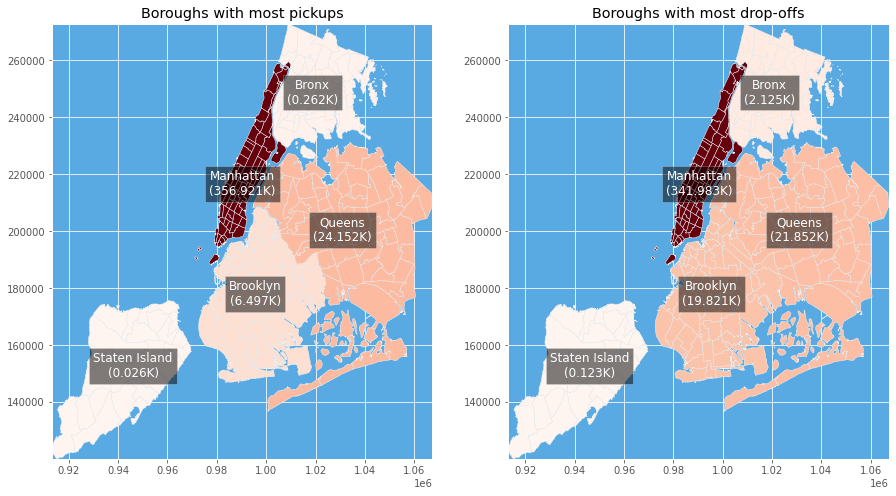

In [ ]:
# display the Boroughs with pick-ups and drop-offs
# subplot(nrows,ncols,plot_number): Divide figure into subgraphs of nrows*ncols
# nrows：Number of rows of subgraphs
# ncols: Number of columns of subgraphs

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

# Find out the differences between short and long distance trips of taking taxi

In [ ]:
# select short distance trips (<24m) as df_short and long distance trips(>=24m) as df_long
df_short = pd.read_sql_query('SELECT pickup_LocationID, dropoff_LocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 24 \
                                 GROUP BY pickup_LocationID, dropoff_LocationID', nyc_database)
df_long = pd.read_sql_query('SELECT pickup_LocationID, dropoff_LocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 24 \
                                 GROUP BY pickup_LocationID, dropoff_LocationID', nyc_database)

In [ ]:
# merge the df_short and df_long dataframe
df = df_short.merge(df_long, on=["pickup_LocationID", "dropoff_LocationID"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips"})
# merge the df and df_loc dataframe
df = df.merge(df_loc[["LocationID", "zone"]], left_on="pickup_LocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="dropoff_LocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})

In [ ]:
# group by pickup_LocationID and select top 3 for short and long distance trips
df_PU = df.groupby("pickup_LocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
PUtop3_short = df_PU.sort_values(by=['short trips'], ascending=False).set_index("pickup_LocationID").head(3)
PUtop3_long = df_PU.sort_values(by=['long trips'], ascending=False).set_index("pickup_LocationID").head(3)
# new dictionaries for pickup counts for short and long distance trips
PUcount_short = dict(zip(df_PU['pickup_LocationID'].tolist(), df_PU['short trips'].tolist()))
PUcount_long = dict(zip(df_PU['pickup_LocationID'].tolist(), df_PU['long trips'].tolist()))

# group by dropoff_LocationID and select top 3 for short and long distance trips
df_DO = df.groupby("dropoff_LocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
DOtop3_short = df_DO.sort_values(by=['short trips'], ascending=False).set_index("dropoff_LocationID").head(3)
DOtop3_long = df_DO.sort_values(by=['long trips'], ascending=False).set_index("dropoff_LocationID").head(3)
# new dictionaries for dropoff counts for short and long distance trips
DOcount_short = dict(zip(df_DO['dropoff_LocationID'].tolist(), df_DO['short trips'].tolist()))
DOcount_long = dict(zip(df_DO['dropoff_LocationID'].tolist(), df_DO['long trips'].tolist()))

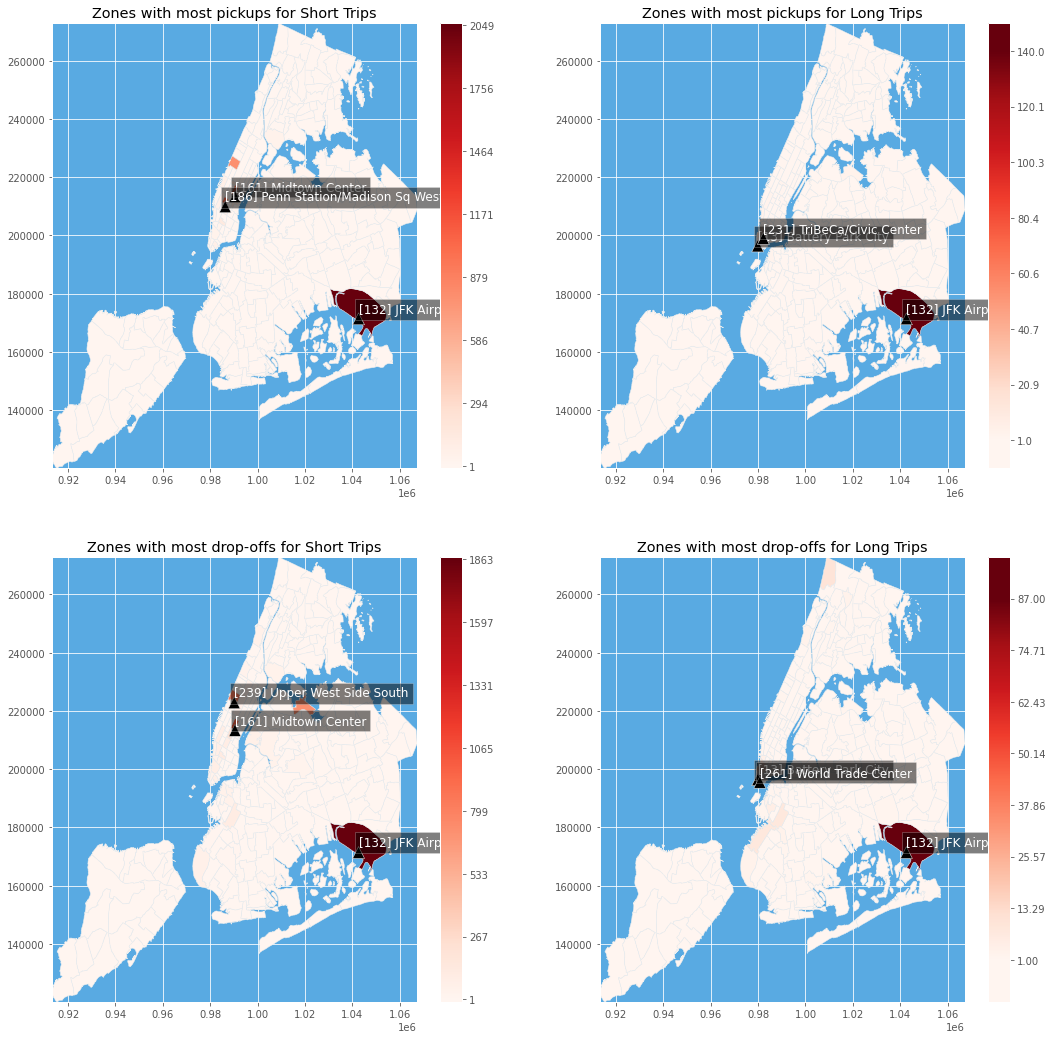

In [ ]:
# display four maps of zones with pick-ups and drop-offs for short and long distance tips
# new 2 rows and 2 columns of subgraphs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())

In [ ]:
# define the function of diff_short_long_trip_on
def diff_short_long_trip_on(attr, rpr="count", kind='bar'):
    # select short distance trips (<24m) as df_short and long distance trips(>=24m) as df_long
    df_short = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance < 24 \
                                    GROUP BY '+attr, nyc_database)
    df_long = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance >= 24 \
                                    GROUP BY '+attr, nyc_database)
    # calculate the proportion
    if rpr == "proportion":
        # Sum all the elements of counts in df_short
        s = np.sum(df_short['count'].values)
        df_short['proportion'] = [float(x)/s for x in df_short['count']]
        # Sum all the elements of counts in df_long
        s = np.sum(df_long['count'].values)
        df_long['proportion'] = [float(x)/s for x in df_long['count']]
    # merge df_short and df_long, return df
    df = df_short.merge(df_long, on=attr, suffixes=["_short", "_long"]) \
                        .rename(columns={rpr+"_short":"short trips", rpr+"_long":"long trips"}) 
    # set the attribute for plot
    ax = df.plot(x=attr, y=['short trips', 'long trips'], kind=kind, figsize=(15,5))
    ax.set_ylabel(rpr) # set proportion as y axis 
    ax.set_title(attr.replace("_", " ")+" difference in short/long trip") # set tittle of plot

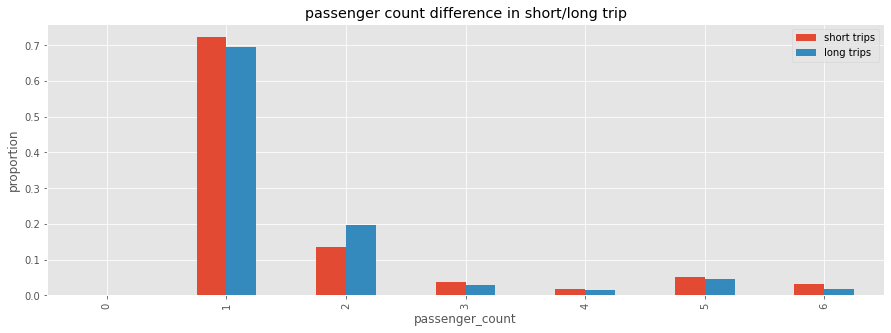

In [ ]:
# select passenger_count as the analysis arrtibute
for attr in ["passenger_count"]:
    # display the bar chart
    diff_short_long_trip_on(attr, rpr="proportion", kind='bar')